In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

Load necessary packages

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

Read necessary csv files

In [3]:
aliases = pd.read_csv("hillary-clinton-emails/Aliases.csv", index_col=0)

In [4]:
emailReceivers = pd.read_csv("hillary-clinton-emails/EmailReceivers.csv", index_col=0)

In [5]:
persons = pd.read_csv("hillary-clinton-emails/Persons.csv", index_col=0)

In [6]:
emails = pd.read_csv("hillary-clinton-emails/Emails.csv", index_col=0)

In [7]:
emails.head(1)

,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,MetadataDocumentClass,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
Id,,,,,,,,,,,,,,,,,,,,,
1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,HRC_Email_296,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...


*Just for fun -- stormtrooper word cloud*

In [8]:
from wordcloud import WordCloud

In [9]:
# concatenate all emails into one text document to be passed into the word cloud
email_full_texts = emails['ExtractedBodyText'].str.cat()

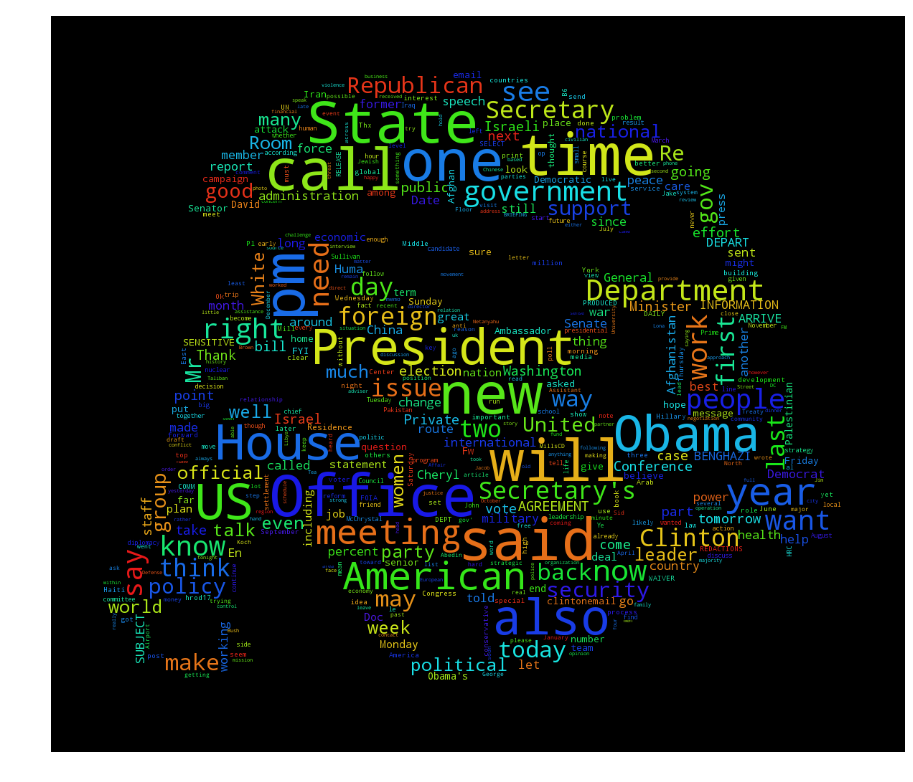

In [69]:
from os import path
from PIL import Image

stormtrooper_mask = np.array(Image.open(path.join(".", "stormtrooper_mask.png")))

#stopwords = set(STOPWORDS)
#stopwords.add("said")

wc = WordCloud(background_color="black", max_words=500, mask=stormtrooper_mask, max_font_size=80)
# generate word cloud
wc.generate(email_full_texts)

# store to file
wc.to_file(path.join(".", "stormtrooper_hillary_emails.png"))

# show
plt.subplots(figsize=(11,11))
plt.imshow(wc)
plt.axis("off")
plt.show()

### Text cleaning / massaging

Before going into topic modelling we do some text preprocessing first.

1) We will work only with the email bodies and start by replacing all NaN values with ''

In [11]:
email_bodies = emails['ExtractedBodyText']

In [12]:
email_bodies.isnull().sum()

1203

In [13]:
email_bodies.fillna("", inplace=True)

In [14]:
email_bodies.isnull().sum()

0

In [15]:
# email example
email_bodies[2]

'B6\nThursday, March 3, 2011 9:45 PM\nH: Latest How Syria is aiding Qaddafi and more... Sid\nhrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx\nMarch 3, 2011\nFor: Hillary'

2) Next we import nltk and its list of stopwords

In [16]:
import nltk
nltk.download()  # Download text data sets, including stop words

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [17]:
from nltk.corpus import stopwords # Import the stop word list
len(stopwords.words("english")) 

153

3) Next we create a preprocessing function for the emails

In [24]:
import re
from bs4 import BeautifulSoup

def preprocess_email(email_body):
    # Function to convert a raw email to a string of words
    # The input is a single string (a raw email), and 
    # the output is a single string (a preprocessed email)

    # 1. Remove the HTML tags or markup (just in case).
    review_text = BeautifulSoup(email_body, "lxml").get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words and words with length 2 or less
    words = [w for w in words if (not w in stops and len(w) > 2 )]
    #
    # 7. Stemming
    porter = nltk.PorterStemmer()
    words = [porter.stem(t) for t in words]
    #
    # 8.The WordNet lemmatizer only removes affixes if the resulting word is in its dictionary
    # wnl = nltk.WordNetLemmatizer()
    # words = [wnl.lemmatize(t) for t in words]
    
    # 9. Join the words back into one string separated by space, and return the result.
    return( " ".join(words)) 

In [27]:
# apply the preprocessing function to each email
# Note: there might be some warnings from Beautiful Soup saying that it found some urls but it cannot retrieve the
# document behind them (not important for the purposes of this project)
email_bodies = email_bodies.map(preprocess_email)

In [28]:
# an example on how the same email given as example above has been modified 
email_bodies[2]

'thursday march latest syria aid qaddafi sid hrc memo syria aid libya docx hrc memo syria aid libya docx march hillari'

### 3. Topic Modelling

In [30]:
import gensim

Prepare the preprocessed email bodies to be used by the lda model from gensim

In [31]:
def get_corpus(texts):
    corpusH = [x.split() for x in texts]
    return corpusH

In [32]:
corpusH = get_corpus(list(email_bodies))

In [60]:
number_of_topics = 10

In [65]:
dictionary = gensim.corpora.Dictionary(corpusH)
tokenizedCorpus = [dictionary.doc2bow(text) for text in corpusH]
lda = gensim.models.ldamodel.LdaModel(corpus=tokenizedCorpus,  num_topics=number_of_topics, id2word = dictionary)

In [66]:
lda.print_topics(number_of_topics)

[(0,
  '0.035*"fyi" + 0.009*"state" + 0.006*"taliban" + 0.006*"call" + 0.006*"afghan" + 0.004*"mcchrystal" + 0.004*"afghanistan" + 0.004*"karzai" + 0.004*"said" + 0.004*"hou"'),
 (1,
  '0.007*"parti" + 0.006*"said" + 0.005*"would" + 0.005*"presid" + 0.005*"polit" + 0.005*"want" + 0.005*"israel" + 0.005*"one" + 0.004*"new" + 0.004*"obama"'),
 (2,
  '0.046*"secretari" + 0.041*"offic" + 0.030*"depart" + 0.024*"meet" + 0.021*"room" + 0.020*"state" + 0.015*"arriv" + 0.014*"rout" + 0.013*"privat" + 0.012*"confer"'),
 (3,
  '0.028*"state" + 0.022*"gov" + 0.016*"cheryl" + 0.013*"mill" + 0.012*"sullivan" + 0.010*"print" + 0.009*"jacob" + 0.008*"monday" + 0.008*"fyi" + 0.006*"sunday"'),
 (4,
  '0.007*"work" + 0.007*"email" + 0.006*"see" + 0.005*"get" + 0.005*"one" + 0.005*"state" + 0.005*"call" + 0.005*"need" + 0.005*"good" + 0.004*"meet"'),
 (5,
  '0.029*"call" + 0.012*"get" + 0.011*"work" + 0.010*"tomorrow" + 0.008*"want" + 0.008*"thank" + 0.007*"also" + 0.007*"time" + 0.007*"back" + 0.007*"to

After testing a few different number of topics, 10 seemed to provide decent sets of words from which a theme could be inferred.

### BONUS: Communication Graph

Before building the communication graph, we need to do some preprocessing.

1) Only keep the emails for which the sender id is not null

In [41]:
senders = emails[emails['SenderPersonId'].isnull() == False]

In [42]:
# test the previous step
senders['SenderPersonId'].isnull().sum()

0

2) Construct a dataframe containing the email ids and the sender and receiver ids for each email respectively

In [43]:
senders_receivers = pd.merge(emailReceivers, senders[['SenderPersonId','DocNumber']], left_on='EmailId', right_index='true', how='inner')

In [44]:
senders_receivers.drop('DocNumber', axis=1, inplace=True)

In [45]:
senders_receivers.rename(columns={'PersonId': 'ReceiverId', 'SenderPersonId': 'SenderId'}, inplace=True)

In [46]:
senders_receivers['SenderId'] = senders_receivers['SenderId'].astype(int)

In [47]:
senders_receivers.head()

,EmailId,ReceiverId,SenderId
Id,,,
1,1,80,87
3,3,228,32
4,3,80,32
5,4,80,32
6,5,81,80


Using the freshly constructed dataframe containing the receiver and sender ids we can build the network.

In [48]:
import community
import networkx as nx

In [49]:
# pass to the graph the ReceiverId and SenderId columns for initialization of the network
G = nx.from_pandas_dataframe(senders_receivers, 'ReceiverId', 'SenderId')

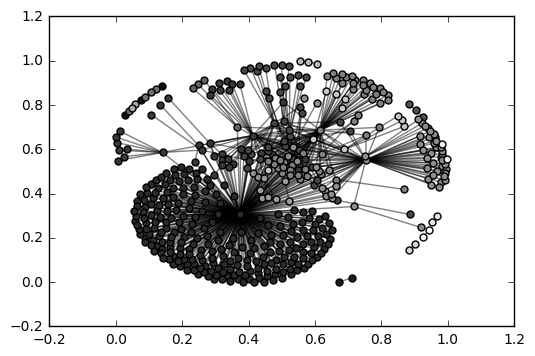

In [50]:
# compute the best partition
partition = community.best_partition(G)

# network visualization
# Note: The nodes in similar color are considered to be from the same partition
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 25,
                                node_color = str(count / size))


nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In the next part we extract the most frequent 20 words used by the members of each partition.

In [51]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

def extract_top_20_words_per_partition(party):
    # overall_party_emails = the concatenation of all emails sent by the members of the current partition
    overall_party_emails = ""
    for author in party:
        # get the email ids for the emails sent by the current author
        author_email_ids = senders_receivers[senders_receivers['SenderId'] == author]
        author_email_ids = author_email_ids['EmailId'].tolist()
        # obtain the (preprocessed) email bodies corresponding to the found email ids for the author
        author_emails = email_bodies[author_email_ids]
        # append the found email bodies to the other emails in the current partition
        overall_party_emails += author_emails.str.cat()
    # find the 20 most common words used in these emails and return the list
    fdist = FreqDist(word.lower() for word in word_tokenize(overall_party_emails))
    return fdist.most_common(20)

In [52]:
def most_common_words_for_each_partition():
    words_per_partition = {}
    # go through each partition
    for com in set(partition.values()) :
        partition_user_ids = [nodes for nodes in partition.keys()
                                    if partition[nodes] == com]
        # store per each partition tag the top 20 most used words
        words_per_partition[com] = extract_top_20_words_per_partition(partition_user_ids)
    return words_per_partition

Get the most common 20 words per each partition

In [53]:
common_words_per_partition = most_common_words_for_each_partition()

In [54]:
# helper function for the printing below
def get_only_words(listy):
    res = []
    for tup in listy:
        res.append(tup[0])
    return res

In [55]:
for key,values in common_words_per_partition.items():
    if(len(values) > 0):
        print("Partition "+str(key)+" :")
        print(get_only_words(values))
        print()

Partition 2 :
['state', 'call', 'see', 'want', 'time', 'gov', 'get', 'would', 'work', 'know', 'need', 'also', 'like', 'meet', 'talk', 'let', 'could', 'mtg', 'ask', 'thank']

Partition 3 :
['state', 'work', 'call', 'govern', 'would', 'said', 'unit', 'depart', 'agreement', 'secur', 'benghazi', 'presid', 'peopl', 'hou', 'case', 'also', 'inform', 'one', 'meet', 'date']

Partition 4 :
['state', 'women', 'said', 'work', 'new', 'clinton', 'would', 'also', 'issu', 'one', 'time', 'think', 'make', 'like', 'get', 'presid', 'govern', 'year', 'nation', 'support']

Partition 6 :
['women', 'year', 'say', 'place', 'richard', 'said', 'jamal', 'first', 'vote', 'deuel', 'one', 'new', 'illinoi', 'time', 'peopl', 'day', 'state', 'republican', 'kid', 'work']

Partition 7 :
['settlement', 'peopl', 'haitian', 'govern', 'work', 'need', 'ingo', 'latrin', 'could', 'plan', 'would', 'though', 'help', 'includ', 'local', 'princ', 'one', 'port', 'committ', 'least']

Partition 8 :
['call', 'want', 'said', 'state', 'hu

In [67]:
lda.print_topics(number_of_topics)

[(0,
  '0.035*"fyi" + 0.009*"state" + 0.006*"taliban" + 0.006*"call" + 0.006*"afghan" + 0.004*"mcchrystal" + 0.004*"afghanistan" + 0.004*"karzai" + 0.004*"said" + 0.004*"hou"'),
 (1,
  '0.007*"parti" + 0.006*"said" + 0.005*"would" + 0.005*"presid" + 0.005*"polit" + 0.005*"want" + 0.005*"israel" + 0.005*"one" + 0.004*"new" + 0.004*"obama"'),
 (2,
  '0.046*"secretari" + 0.041*"offic" + 0.030*"depart" + 0.024*"meet" + 0.021*"room" + 0.020*"state" + 0.015*"arriv" + 0.014*"rout" + 0.013*"privat" + 0.012*"confer"'),
 (3,
  '0.028*"state" + 0.022*"gov" + 0.016*"cheryl" + 0.013*"mill" + 0.012*"sullivan" + 0.010*"print" + 0.009*"jacob" + 0.008*"monday" + 0.008*"fyi" + 0.006*"sunday"'),
 (4,
  '0.007*"work" + 0.007*"email" + 0.006*"see" + 0.005*"get" + 0.005*"one" + 0.005*"state" + 0.005*"call" + 0.005*"need" + 0.005*"good" + 0.004*"meet"'),
 (5,
  '0.029*"call" + 0.012*"get" + 0.011*"work" + 0.010*"tomorrow" + 0.008*"want" + 0.008*"thank" + 0.007*"also" + 0.007*"time" + 0.007*"back" + 0.007*"to

After roughly analyzing the topics obtained through lda and through the most frequent sets of words of each partion, it is hard to see any specific straight relation between the 2 sets of topics.

Nonetheless there is at least a case where there is a close similarity, i.e. between the topic indexed as 1 from the lda and Partition 9 from the network.

From the word frequency in each community, you can generally get an idea of what it is the main topic of conversation, though one needs to think about the words a little bit to get the gist of the theme, on the other hand there are also partitions like Partition 16 which makes little sense.